In [1]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler



In [2]:
# Check CUDA availability
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device after setting: {device}')

CUDA Available: True
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU
Device after setting: cuda:0


In [3]:
# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}


In [4]:
data_dir = 'ILSVRC/Data/CLS-LOC'

# Datasets
image_datasets = {
    'train': datasets.ImageFolder(
        os.path.join(data_dir, 'train'),
        data_transforms['train']),
    'val': datasets.ImageFolder(
        os.path.join(data_dir, 'val'),
        data_transforms['val'])
}

batch_size = 64  # Adjust based on your GPU memory
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], batch_size=batch_size,
        shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'], batch_size=batch_size,
        shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)


In [5]:
# Dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Initialize the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features

# Add dropout to the fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

# Move the model to the device
model = model.to(device)
print(f'Model is on device: {next(model.parameters()).device}')

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model is on device: cuda:0


In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=150):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_train_acc = 0.0  # For tracking the best training accuracy
    best_val_acc = 0.0    # For tracking the best validation accuracy
    best_loss = float('inf')  # For tracking the best validation loss

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass and track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Compute epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Update best training accuracy
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc

            # Update best validation accuracy and save model weights
            if phase == 'val':
                scheduler.step()  # For StepLR, call without arguments

                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # Update best validation loss if needed
                if epoch_loss < best_loss:
                    best_loss = epoch_loss

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m '
          f'{time_elapsed % 60:.0f}s')
    print(f'Best Training Acc: {best_train_acc:.4f}')
    print(f'Best Validation Acc: {best_val_acc:.4f}')
    print(f'Best Validation Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [13]:
if __name__ == '__main__':
    model = train_model(
        model, criterion, optimizer, scheduler, num_epochs=150)


Epoch 0/149
----------
train Loss: 0.4532 Acc: 0.8422
val Loss: 1.4222 Acc: 0.7045

Epoch 1/149
----------
train Loss: 0.4450 Acc: 0.8430
val Loss: 0.8418 Acc: 0.7520

Epoch 2/149
----------
train Loss: 0.4656 Acc: 0.8348
val Loss: 0.9674 Acc: 0.7282

Epoch 3/149
----------
train Loss: 0.4461 Acc: 0.8424
val Loss: 1.0649 Acc: 0.7150

Epoch 4/149
----------
train Loss: 0.4721 Acc: 0.8353
val Loss: 0.9126 Acc: 0.7388

Epoch 5/149
----------
train Loss: 0.4487 Acc: 0.8406
val Loss: 1.0143 Acc: 0.7230

Epoch 6/149
----------
train Loss: 0.4367 Acc: 0.8447
val Loss: 0.9274 Acc: 0.7441

Epoch 7/149
----------
train Loss: 0.4510 Acc: 0.8435
val Loss: 0.9166 Acc: 0.7467

Epoch 8/149
----------
train Loss: 0.4202 Acc: 0.8484
val Loss: 1.1296 Acc: 0.7256

Epoch 9/149
----------
train Loss: 0.4368 Acc: 0.8463
val Loss: 0.9419 Acc: 0.7150

Epoch 10/149
----------
train Loss: 0.4351 Acc: 0.8509
val Loss: 1.1550 Acc: 0.7124

Epoch 11/149
----------
train Loss: 0.4512 Acc: 0.8461
val Loss: 1.1133 Acc

In [14]:
class_id_to_name = {}
with open('ILSVRC/LOC_synset_mapping.txt', 'r') as f:
    for line_number, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            # Skip empty lines
            continue
        parts = line.split(' ', 1)
        if len(parts) == 2:
            class_id_to_name[parts[0]] = parts[1]
        else:
            print(f"Warning: Line {line_number} is not in the expected format and will be skipped: '{line}'")

# Map class indices to class IDs
idx_to_class_id = {v: k for k, v in image_datasets['train'].class_to_idx.items()}


In [15]:
torch.save(model.state_dict(), 'resnet50_from_scratch.pth')


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                class_id = idx_to_class_id[preds[j].item()]
                class_name = class_id_to_name.get(class_id, 'Unknown')
                print(f'Predicted: {class_name}')
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

# Visualize some predictions
visualize_model(model)


Predicted: tench, Tinca tinca
Predicted: tench, Tinca tinca
Predicted: tench, Tinca tinca
Predicted: tench, Tinca tinca
Predicted: tench, Tinca tinca
Predicted: tench, Tinca tinca


# New ICE

In [20]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.models as models
import ICE.Explainer as Explainer
import ICE.ModelWrapper as ModelWrapper
import ICE.utils as utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Define all 10 classes
all_class_names = ['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475',
                   'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01518878']


# Define the class_id_to_name dictionary
class_id_to_name = {
    'n01440764': 'tench, Tinca tinca',
    'n01443537': 'goldfish, Carassius auratus',
    'n01484850': 'great white shark, white shark, Carcharodon carcharias',
    'n01491361': 'tiger shark, Galeocerdo cuvieri',
    'n01494475': 'hammerhead, hammerhead shark',
    'n01496331': 'electric ray, crampfish, numbfish, torpedo',
    'n01498041': 'stingray',
    'n01514668': 'cock',
    'n01514859': 'hen',
    'n01518878': 'ostrich, Struthio camelus'
}


# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your dataset
data_dir = 'ILSVRC/Data/CLS-LOC'
batch_size = 32

# Create the datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}
# Map class names to indices
class_to_idx = image_datasets['train'].class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Define target classes (use the indices corresponding to your 10 classes)
target_classes = [class_to_idx[class_name] for class_name in all_class_names]
loaders = []
for target in target_classes:
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == target]
    class_dataset = torch.utils.data.Subset(image_datasets['train'], class_indices)
    loaders.append(torch.utils.data.DataLoader(class_dataset, batch_size=batch_size, shuffle=True, num_workers=4))
    # print(len(loaders))
val_loaders = []
for target in target_classes:
    class_indices = [i for i, label in enumerate(image_datasets['val'].targets) if label == target]
    class_dataset = torch.utils.data.Subset(image_datasets['val'], class_indices)
    val_loaders.append(torch.utils.data.DataLoader(class_dataset, batch_size=batch_size, shuffle=False, num_workers=4))


# Tench, Tinca tinca

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 53.85288429260254 s.
3/5 Error estimated, fidelity: [0.1156959  0.0941355  0.16593732 0.13527992 0.16799436 0.16327957
 0.15033296 0.08592348 0.13671186 0.15014502].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 28, 30, 34, 36, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 54, 56, 58, 60, 62, 63, 64, 66, 67, 68, 69, 71, 73, 74, 79, 80, 81, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 99, 102, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10


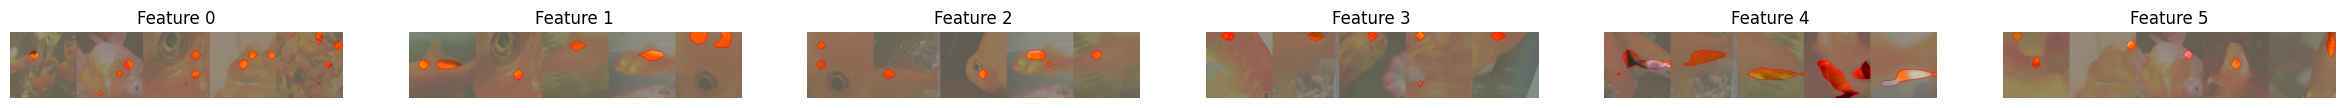

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


NCAV Classification Accuracy: 74.41%
              precision    recall  f1-score   support

   n01440764       0.88      0.88      0.88        48
   n01443537       0.82      0.95      0.88        19
   n01484850       0.78      0.71      0.74        45
   n01491361       0.59      0.68      0.63        40
   n01494475       0.71      0.66      0.68        38
   n01496331       0.66      0.66      0.66        41
   n01498041       0.59      0.55      0.57        40
   n01514668       0.81      0.75      0.78        40
   n01514859       0.64      0.78      0.70        27
   n01518878       0.97      0.93      0.95        41

    accuracy                           0.74       379
   macro avg       0.74      0.75      0.75       379
weighted avg       0.75      0.74      0.74       379



In [21]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01440764'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="tench",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()

# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=10, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))



# Goldfish, Carassius auratus

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 64.53060483932495 s.
3/5 Error estimated, fidelity: [0.13201241 0.08454697 0.1823468  0.15788448 0.17643788 0.16277807
 0.16055856 0.09164176 0.12717854 0.14241609].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 28, 29, 30, 33, 34, 36, 37, 42, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 60, 62, 63, 64, 66, 67, 68, 70, 73, 74, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 94, 95, 96, 97, 102, 103, 105, 106, 107, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
Done w

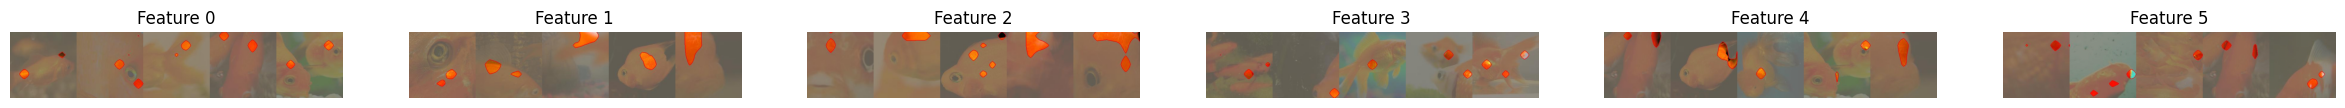

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 78.10%
              precision    recall  f1-score   support

   n01440764       0.92      0.92      0.92        48
   n01443537       0.86      0.95      0.90        19
   n01484850       0.76      0.76      0.76        45
   n01491361       0.66      0.68      0.67        40
   n01494475       0.73      0.71      0.72        38
   n01496331       0.71      0.71      0.71        41
   n01498041       0.68      0.62      0.65        40
   n01514668       0.94      0.75      0.83        40
   n01514859       0.63      0.89      0.74        27
   n01518878       0.97      0.93      0.95        41

    accuracy                           0.78       379
   macro avg       0.78      0.79      0.78       379
weighted avg       0.79      0.78      0.78       379



In [22]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01443537'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="goldfish",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Great white shark, white shark, Carcharodon carcharias

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 70.68780589103699 s.
3/5 Error estimated, fidelity: [0.11277047 0.08787773 0.14337963 0.15102073 0.17904099 0.14533851
 0.14971347 0.09743815 0.11676228 0.14817935].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 31, 33, 34, 35, 36, 37, 38, 40, 42, 44, 46, 48, 49, 52, 53, 54, 55, 57, 59, 62, 66, 67, 69, 71, 73, 75, 76, 79, 82, 83, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
Done with class:

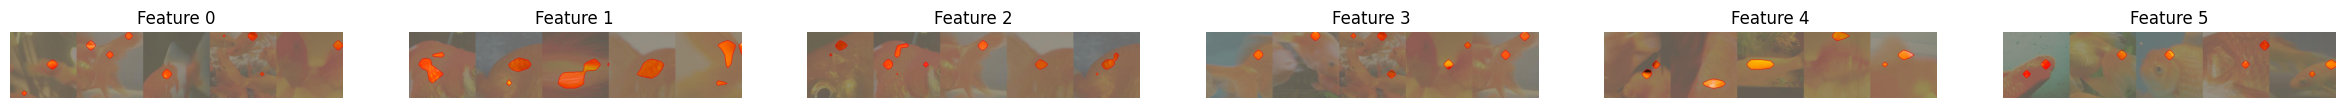

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 75.46%
              precision    recall  f1-score   support

   n01440764       0.91      0.90      0.91        48
   n01443537       0.86      0.95      0.90        19
   n01484850       0.75      0.73      0.74        45
   n01491361       0.62      0.65      0.63        40
   n01494475       0.73      0.71      0.72        38
   n01496331       0.63      0.63      0.63        41
   n01498041       0.60      0.53      0.56        40
   n01514668       0.85      0.70      0.77        40
   n01514859       0.62      0.93      0.75        27
   n01518878       1.00      0.95      0.97        41

    accuracy                           0.75       379
   macro avg       0.76      0.77      0.76       379
weighted avg       0.76      0.75      0.75       379



In [23]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01484850'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="great white shark",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Tiger shark, Galeocerdo cuvieri

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 54.16930532455444 s.
3/5 Error estimated, fidelity: [0.11804539 0.08790429 0.14152541 0.12311237 0.16587632 0.16238053
 0.15305489 0.10122519 0.1430947  0.14600108].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 25, 26, 29, 30, 31, 35, 37, 39, 40, 42, 43, 45, 46, 49, 52, 55, 57, 58, 59, 60, 64, 66, 68, 69, 72, 73, 74, 75, 76, 78, 79, 80, 82, 84, 86, 87, 88, 89, 91, 92, 93, 94, 96, 97, 98, 99, 100, 104, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
D

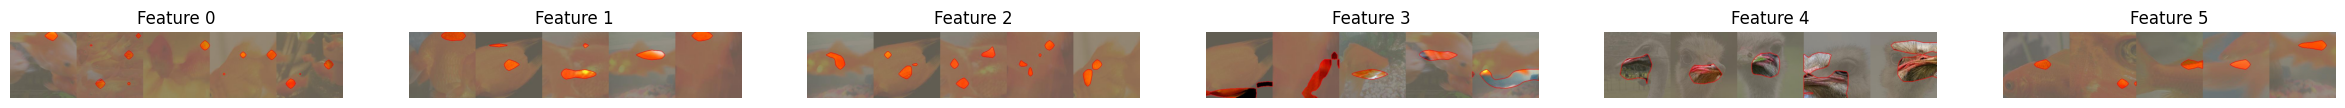

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 77.04%
              precision    recall  f1-score   support

   n01440764       0.92      0.92      0.92        48
   n01443537       0.76      1.00      0.86        19
   n01484850       0.73      0.78      0.75        45
   n01491361       0.67      0.70      0.68        40
   n01494475       0.79      0.68      0.73        38
   n01496331       0.62      0.63      0.63        41
   n01498041       0.63      0.55      0.59        40
   n01514668       0.86      0.80      0.83        40
   n01514859       0.71      0.81      0.76        27
   n01518878       1.00      0.93      0.96        41

    accuracy                           0.77       379
   macro avg       0.77      0.78      0.77       379
weighted avg       0.77      0.77      0.77       379



In [24]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01491361'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="tiger shark",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Hammerhead, hammerhead shark

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 57.14434552192688 s.
3/5 Error estimated, fidelity: [0.12789168 0.09256047 0.16640963 0.143953   0.1992177  0.17272411
 0.17577451 0.1072653  0.14206274 0.17533074].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 54, 57, 59, 63, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 79, 83, 85, 86, 88, 92, 93, 94, 95, 96, 97, 98, 104, 105, 107, 109, 110, 112, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
Done with cla

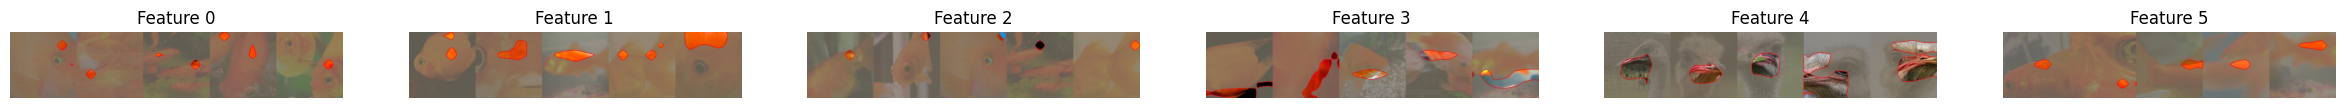

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 77.84%
              precision    recall  f1-score   support

   n01440764       0.92      0.94      0.93        48
   n01443537       0.86      0.95      0.90        19
   n01484850       0.78      0.84      0.81        45
   n01491361       0.64      0.68      0.66        40
   n01494475       0.79      0.71      0.75        38
   n01496331       0.66      0.66      0.66        41
   n01498041       0.64      0.57      0.61        40
   n01514668       0.88      0.75      0.81        40
   n01514859       0.65      0.81      0.72        27
   n01518878       0.97      0.93      0.95        41

    accuracy                           0.78       379
   macro avg       0.78      0.78      0.78       379
weighted avg       0.78      0.78      0.78       379



In [25]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01494475'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="tiger shark",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Electric ray, crampfish, numbfish, torpedo

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 68.46310949325562 s.
3/5 Error estimated, fidelity: [0.11857005 0.08004315 0.16305841 0.14356705 0.17282779 0.15966135
 0.1535953  0.09088719 0.13455474 0.1486182 ].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 31, 33, 35, 36, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 52, 53, 54, 56, 58, 61, 63, 65, 66, 68, 69, 70, 73, 74, 75, 76, 81, 83, 84, 85, 86, 87, 88, 91, 95, 96, 97, 99, 100, 102, 103, 104, 106, 107, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331,

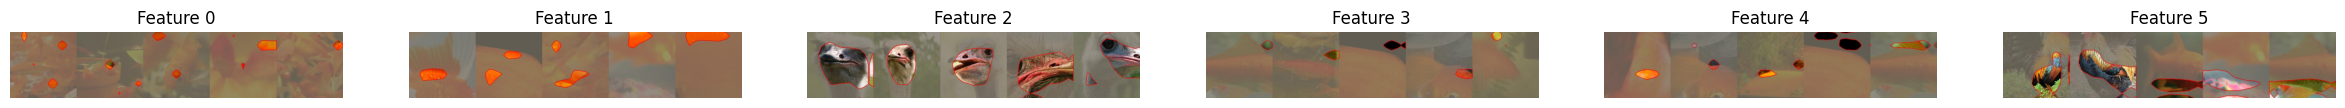

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 74.93%
              precision    recall  f1-score   support

   n01440764       0.94      0.92      0.93        48
   n01443537       0.75      0.95      0.84        19
   n01484850       0.78      0.69      0.73        45
   n01491361       0.59      0.68      0.63        40
   n01494475       0.69      0.66      0.68        38
   n01496331       0.67      0.63      0.65        41
   n01498041       0.57      0.57      0.57        40
   n01514668       0.86      0.75      0.80        40
   n01514859       0.69      0.81      0.75        27
   n01518878       0.95      0.93      0.94        41

    accuracy                           0.75       379
   macro avg       0.75      0.76      0.75       379
weighted avg       0.75      0.75      0.75       379



In [26]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01496331'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="electric ray",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Stingray

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 58.2775354385376 s.
3/5 Error estimated, fidelity: [0.13168118 0.0897803  0.15145615 0.14725362 0.18159189 0.18361829
 0.15620319 0.09973891 0.14580878 0.1562148 ].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 33, 34, 35, 36, 37, 39, 41, 42, 44, 46, 47, 49, 54, 55, 56, 58, 60, 62, 64, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 82, 84, 85, 86, 87, 91, 92, 93, 96, 97, 98, 100, 102, 104, 105, 108, 109, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n0149

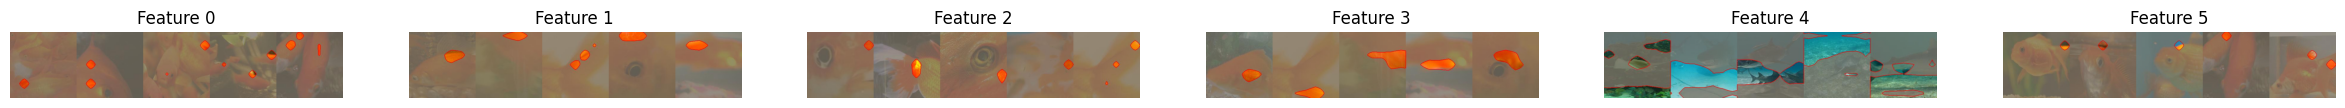

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 76.78%
              precision    recall  f1-score   support

   n01440764       0.92      0.94      0.93        48
   n01443537       0.80      0.84      0.82        19
   n01484850       0.77      0.73      0.75        45
   n01491361       0.61      0.68      0.64        40
   n01494475       0.71      0.71      0.71        38
   n01496331       0.68      0.66      0.67        41
   n01498041       0.66      0.62      0.64        40
   n01514668       0.82      0.78      0.79        40
   n01514859       0.72      0.85      0.78        27
   n01518878       1.00      0.90      0.95        41

    accuracy                           0.77       379
   macro avg       0.77      0.77      0.77       379
weighted avg       0.77      0.77      0.77       379



In [27]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01498041'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="stingray",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Cock

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 69.25203394889832 s.
3/5 Error estimated, fidelity: [0.1157699  0.0842978  0.15405189 0.11728746 0.18071113 0.1486615
 0.15996791 0.09361714 0.12394086 0.13414808].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 28, 33, 34, 36, 37, 38, 40, 44, 45, 48, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 66, 67, 68, 71, 73, 74, 76, 80, 81, 82, 83, 87, 90, 92, 95, 96, 97, 99, 101, 102, 103, 104, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
Done with 

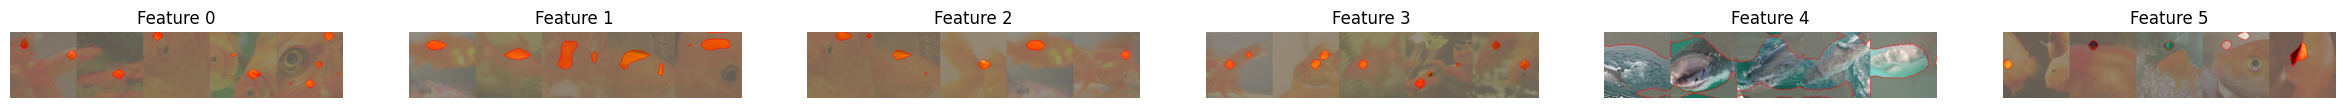

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 78.36%
              precision    recall  f1-score   support

   n01440764       0.92      0.96      0.94        48
   n01443537       0.82      0.95      0.88        19
   n01484850       0.77      0.80      0.78        45
   n01491361       0.68      0.68      0.68        40
   n01494475       0.73      0.79      0.76        38
   n01496331       0.68      0.63      0.66        41
   n01498041       0.59      0.50      0.54        40
   n01514668       0.92      0.82      0.87        40
   n01514859       0.77      0.85      0.81        27
   n01518878       0.93      0.93      0.93        41

    accuracy                           0.78       379
   macro avg       0.78      0.79      0.78       379
weighted avg       0.78      0.78      0.78       379



In [28]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01514668'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="cock",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Hen

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 66.39114475250244 s.
3/5 Error estimated, fidelity: [0.12317005 0.090927   0.17564023 0.14874805 0.18455874 0.16869698
 0.15711217 0.09224682 0.13307006 0.13830107].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 31, 33, 34, 36, 37, 39, 40, 41, 42, 44, 46, 47, 48, 50, 51, 52, 53, 56, 57, 59, 61, 62, 63, 64, 69, 73, 74, 76, 78, 82, 83, 84, 85, 87, 89, 92, 93, 94, 95, 98, 99, 101, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6/10
Done w

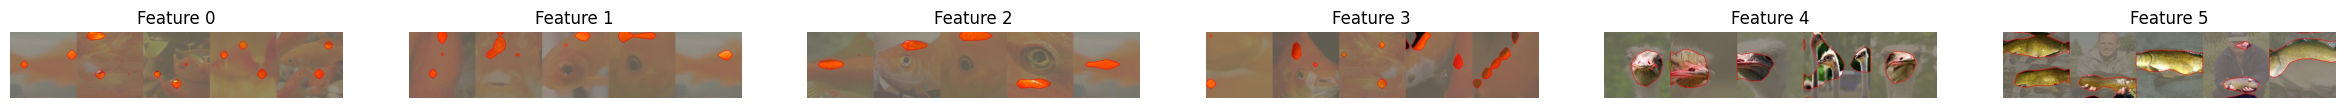

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 76.25%
              precision    recall  f1-score   support

   n01440764       0.90      0.92      0.91        48
   n01443537       0.76      1.00      0.86        19
   n01484850       0.77      0.73      0.75        45
   n01491361       0.65      0.70      0.67        40
   n01494475       0.72      0.68      0.70        38
   n01496331       0.67      0.63      0.65        41
   n01498041       0.61      0.57      0.59        40
   n01514668       0.86      0.75      0.80        40
   n01514859       0.67      0.81      0.73        27
   n01518878       1.00      0.93      0.96        41

    accuracy                           0.76       379
   macro avg       0.76      0.77      0.76       379
weighted avg       0.77      0.76      0.76       379



In [29]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01514859'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="hen",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))


# Ostrich, Struthio camelus

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training reducer:
1/5 Featuer maps gathered.
dataset too big, train with 0.08 instances
loading complete, with size of (996, 7, 7, 2048)
2/5 Reducer trained, spent 62.740575075149536 s.
3/5 Error estimated, fidelity: [0.11673256 0.08582393 0.14705324 0.12779063 0.17353732 0.17785272
 0.14760525 0.08262054 0.12860012 0.14379043].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 33, 34, 37, 39, 40, 41, 43, 44, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 67, 68, 72, 74, 77, 78, 82, 83, 84, 85, 87, 88, 89, 90, 92, 93, 95, 96, 98, 101, 102, 103, 106, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
loading training data
Done with class: n01440764, 1/10
Done with class: n01443537, 2/10
Done with class: n01484850, 3/10
Done with class: n01491361, 4/10
Done with class: n01494475, 5/10
Done with class: n01496331, 6

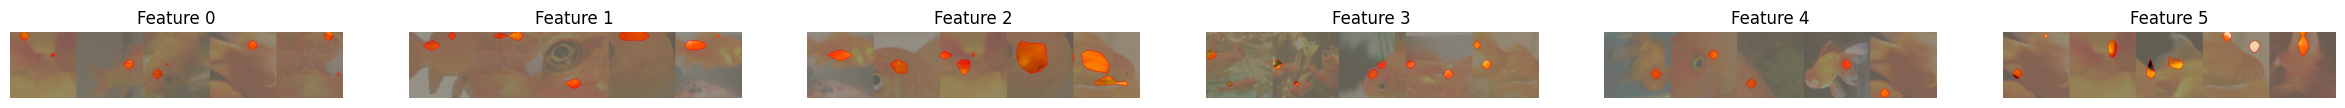

c:\Users\olnij\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


NCAV Classification Accuracy: 76.78%
              precision    recall  f1-score   support

   n01440764       0.88      0.90      0.89        48
   n01443537       0.81      0.89      0.85        19
   n01484850       0.80      0.73      0.77        45
   n01491361       0.63      0.68      0.65        40
   n01494475       0.67      0.68      0.68        38
   n01496331       0.71      0.66      0.68        41
   n01498041       0.62      0.65      0.63        40
   n01514668       0.86      0.80      0.83        40
   n01514859       0.76      0.81      0.79        27
   n01518878       0.95      0.93      0.94        41

    accuracy                           0.77       379
   macro avg       0.77      0.77      0.77       379
weighted avg       0.77      0.77      0.77       379



In [30]:
# Load and prepare the model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
num_classes = len(all_class_names)  # Ensure num_classes is defined
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

desired_class_name = 'n01518878'
class_index = all_class_names.index(desired_class_name)
image_index = 5  # Change to select a different image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Load your trained model weights
# Replace 'resnet50_10classes.pth' with your model's filename
model.load_state_dict(torch.load('resnet50_from_scratch.pth', map_location=device, weights_only=True))

# Set the model to evaluation mode
model.eval()

wm = ModelWrapper.PytorchModelWrapper(
    model,
    batch_size=batch_size,
    predict_target=list(range(num_classes)),
    input_size=[3, 224, 224],
    input_channel_first=True,  # Set to True if your data is in channels-first format
    model_channel_first=True   # Set to True if your model expects channels-first input
)

explainer = Explainer.Explainer(
    title="ostrich",
    layer_name="layer4",  # The layer from which to extract features
    class_names=all_class_names,
    utils=utils.img_utils(img_size=(224, 224), nchannels=3, img_format='channels_first', mode='torch'),
    n_components=128,
    reducer_type="NMF"  # Non-negative Matrix Factorization
)
try:
    # Train the reducer and estimate weights
    explainer.train_model(wm, loaders)
    
    # Generate feature visualizations
    explainer.generate_features(wm, loaders)
    
    # Generate global explanations
    explainer.global_explanations()
    
    print("Explanations generated successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
try:
    # Get a batch of images from one of the loaders
    sample_inputs, sample_labels = next(iter(loaders[4]))
    sample_input = sample_inputs[30].unsqueeze(0).to(device)  # Select the first image and add batch dimension
    
    # Generate local explanations
    explainer.local_explanations(sample_input, wm, name="sample_explanation")
    # explainer.local_explanations(sample_input, wm, target_classes=[class_index], name=f"explanation_class_{desired_class_name}_image_{image_index}")
    
    print("Local explanation generated successfully!")
except Exception as e:
    print(f"An error occurred during local explanation: {str(e)}")
    import traceback
    traceback.print_exc()
# Visualize the top features
feature_dir = os.path.join('Explainers', explainer.title, 'feature_imgs')
feature_files = sorted([f for f in os.listdir(feature_dir) if f.endswith('.jpg')])

# Display first few features
num_features_to_display = min(6, len(feature_files))
fig, axes = plt.subplots(1, num_features_to_display, figsize=(5 * num_features_to_display, 5))

for idx in range(num_features_to_display):
    feature_file = feature_files[idx]
    image_path = os.path.join(feature_dir, feature_file)
    if os.path.exists(image_path):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Feature {idx}')
    else:
        print(f'Feature image {feature_file} not found.')
plt.show()
# Function to get ResNet predictions
def get_resnet_predictions(model_wrapper, loaders):
    all_predictions = []
    all_labels = []
    for class_idx, loader in enumerate(loaders):
        class_predictions = []
        class_labels = []
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            with torch.no_grad():
                outputs = model_wrapper.predict(inputs)
                preds = outputs.argmax(axis=1).cpu().numpy()
                class_predictions.append(preds)
                class_labels.append(labels)
        class_predictions = np.concatenate(class_predictions)
        class_labels = np.concatenate(class_labels)
        all_predictions.append(class_predictions)
        all_labels.append(class_labels)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    return all_predictions, all_labels

# Function to get NCAV projections
def get_ncav_projections(model_wrapper, explainer, loaders):
    projections = []
    labels = []
    for class_idx, loader in enumerate(loaders):
        class_projections = []
        class_labels = []
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            labels_batch = labels_batch.numpy()
            # Get activations from the target layer
            activations = model_wrapper.get_feature(inputs, explainer.layer_name)
            # No need to convert activations to CPU and NumPy array
            # Transform activations using the reducer (e.g., NMF)
            reduced_activations = explainer.reducer.transform(activations)
            reduced_activations = reduced_activations.reshape(len(inputs), -1)
            class_projections.append(reduced_activations)
            class_labels.append(labels_batch)
        class_projections = np.concatenate(class_projections)
        class_labels = np.concatenate(class_labels)
        projections.append(class_projections)
        labels.append(class_labels)
    projections = np.concatenate(projections)
    labels = np.concatenate(labels)
    return projections, labels


# Get projections and labels from training data
train_projections, train_labels = get_ncav_projections(wm, explainer, loaders)

# Train the classifier
classifier = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
classifier.fit(train_projections, train_labels)

# Get projections and labels from validation data (used as test data)
test_projections, test_labels = get_ncav_projections(wm, explainer, val_loaders)

# Predict using NCAVs
ncav_predictions = classifier.predict(test_projections)

# Calculate accuracy
accuracy = accuracy_score(test_labels, ncav_predictions)
print(f"NCAV Classification Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(test_labels, ncav_predictions, target_names=all_class_names))
